#  Tradução de Textos - Experimento
## Utilização do modelo [MarianMT](https://huggingface.co/transformers/model_doc/marian.html) para tradução. 


* Neste exempo a tradução é feito do inglês para o português, mas ela pode ser feita em qualquer uma das línguas suportadas pelo MarianMT. 
* Para adaptar para traduções em outras línguas é necessário verificacar se há o modelo pré treinado disponível no MarianMT e adaptar o truncamento de strings do [spacy](https://spacy.io/usage/models) para o idioma desejado
* A métrica computada é o [sacrebleu](https://https://github.com/mjpost/sacrebleu) 


### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [1]:
dataset = "/tmp/data/paracrawl_en_pt_test.csv" #@param {type:"string"}
input_column_name = "text_english" #@param {type:"string", label:"Atributo do texto", description:"Este atributo será traduzido e apresentado o resultado."}
reference_column_name = "text_portuguese" #@param {type:"string", label:"Atributo alvo", description:"Seu modelo será validado com os valores do alvo."}
output_column_name = "translated_text_portuguese" #@param {type:"string", label:"Coluna com as traduções geradas"}
input_language = "Inglês" #@param ["Alemão", "Catalão", "Espanhol", "Francês", "Inglês", "Italiano", "Latim", "Português", "Romeno"] {type:"string", label:"Idioma de entrada"}
target_language = "Português" #@param ["Alemão", "Catalão", "Espanhol", "Francês", "Inglês", "Italiano", "Latim", "Português", "Romeno"] {type:"string", label:"Idioma de saída"}
calculate_metrics = True #@param {type:"boolean",label:"Calcular métricas",description:"Métrica entre o texto gerado e o texto de referência"}
        
#Hyperparams 
seed = 42 #@param {type:"integer",label"Semente de aleatoriedade"}
max_length = 256 #@param {type:"integer",label"Tamanho máximo da sentença de entrada que entrará no MarianMT. Se a sentença for maior ela será quebrada"}
#model_name = 'Helsinki-NLP/opus-mt-ROMANCE-en' #@param ["Helsinki-NLP/opus-mt-ROMANCE-en","Helsinki-NLP/opus-mt-en-ROMANCE"] {type:"integer",label:"Helsinki/NLP model name"}
inference_batch_size = 2 #@param {type:"integer",label"Tamanho do Batch de inferência"}

In [2]:
if input_language == target_language:
    raise Exception('Idioma de entrada e de saída não podem ser iguais')

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [3]:
import pandas as pd

df = pd.read_csv(dataset)
df = df.dropna()
columns = df.columns

## Verificando as configurações do MarianMT

- Verificando disponibilidade de GPU e status de hardware
- Instanciando modelo e tokenizador
- Opções de tradução de idiomas
- Modelos pré treinados disponíveis

In [4]:
from multiprocessing import cpu_count
import torch

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)

if dev == "cpu":
    print(f"number of CPU cores: {cpu_count()}")
else:
    print(f"GPU: {torch.cuda.get_device_name(0)}, number of CPU cores: {cpu_count()}")

GPU: Tesla T4, number of CPU cores: 8


## Chamada da Classe MarianMT

In [5]:
if input_language=='Inglês' and target_language!='Inglês':
    models_list = ["Helsinki-NLP/opus-mt-en-ROMANCE"]
elif input_language!='Inglês' and target_language=='Inglês':
    models_list = ["Helsinki-NLP/opus-mt-ROMANCE-en"]
else:
    models_list = ["Helsinki-NLP/opus-mt-ROMANCE-en","Helsinki-NLP/opus-mt-en-ROMANCE"]    

In [6]:
from marianmt_model import MarianMTTranslator

    
hyperparams = {'max_length': max_length, 
               'inference_batch_size': inference_batch_size,
               'target_language':target_language,
               'models_list':models_list,
                'seed':seed
              }

marianmt_model = MarianMTTranslator(hyperparams)

In [7]:
reference_column_name = reference_column_name if calculate_metrics else None
df_result = marianmt_model.get_result_dataframe(df_input = df,
                                                input_column_name=input_column_name,
                                                output_column_name=output_column_name,
                                                reference_column_name=reference_column_name)

## Visualizando os resultados 

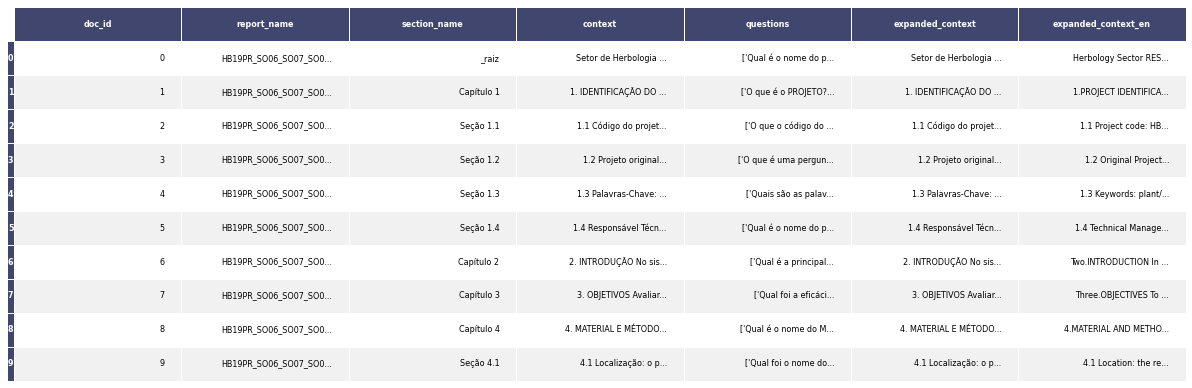

In [8]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table
ax = plot_data_table(df_result)
plt.show()

In [9]:
df_result.to_csv(dataset, index=False)

## Salva métricas

Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [ ]:
from platiagro import save_metrics

if reference_column_name:
    save_metrics(avg_bleu=marianmt_model.avg_bleu)

## Salva resultados da tarefa 

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.

In [ ]:
from joblib import dump

artifacts = {
    "model": marianmt_model,
    "all_input_columns":columns,
    "input_column_name":input_column_name,
    "reference_column_name":reference_column_name,
    "output_column_name":output_column_name,  
}

dump(artifacts, "/tmp/data/translate.joblib")